In [1]:
import pyspark as ps

In [2]:
sc = ps.SparkContext()

In [3]:
sc.master

'local[*]'

In [4]:
posts = sc.textFile('data/Posts.xml')

In [6]:
posts.take(12)

['  <row Id="1" PostTypeId="1" AcceptedAnswerId="15" CreationDate="2010-07-19T19:12:12.510" Score="48" ViewCount="4280" Body="&lt;p&gt;How should I elicit prior distributions from experts when fitting a Bayesian model?&lt;/p&gt;&#xA;" OwnerUserId="8" LastActivityDate="2020-11-05T09:44:51.710" Title="Eliciting priors from experts" Tags="&lt;bayesian&gt;&lt;prior&gt;&lt;elicitation&gt;" AnswerCount="6" CommentCount="1" FavoriteCount="32" ContentLicense="CC BY-SA 2.5" />',
 '  <row Id="2" PostTypeId="1" AcceptedAnswerId="59" CreationDate="2010-07-19T19:12:57.157" Score="34" ViewCount="32048" Body="&lt;p&gt;In many different statistical methods there is an &quot;assumption of normality&quot;.  What is &quot;normality&quot; and how do I know if there is normality?&lt;/p&gt;&#xA;" OwnerUserId="24" LastEditorDisplayName="user88" LastEditDate="2010-08-07T17:56:44.800" LastActivityDate="2017-11-22T12:15:07.030" Title="What is normality?" Tags="&lt;distributions&gt;&lt;normality-assumption&gt;" 

In [6]:
import xml.etree.ElementTree as etree

In [7]:
element = etree.fromstring(posts.take(3)[2]) 

In [8]:
element

<Element 'row' at 0x7fb2287703b0>

In [9]:
element.items()

[('Id', '1'),
 ('PostTypeId', '1'),
 ('AcceptedAnswerId', '15'),
 ('CreationDate', '2010-07-19T19:12:12.510'),
 ('Score', '48'),
 ('ViewCount', '4280'),
 ('Body',
  '<p>How should I elicit prior distributions from experts when fitting a Bayesian model?</p>\n'),
 ('OwnerUserId', '8'),
 ('LastActivityDate', '2020-11-05T09:44:51.710'),
 ('Title', 'Eliciting priors from experts'),
 ('Tags', '<bayesian><prior><elicitation>'),
 ('AnswerCount', '6'),
 ('CommentCount', '1'),
 ('FavoriteCount', '32'),
 ('ContentLicense', 'CC BY-SA 2.5')]

In [10]:
# filter valid row XML
# convert data into proper types
# convert RDD into DataFrame

In [11]:
def validate_post(xml):
    try:
        row = etree.fromstring(xml)
        if row.get('Id'):
            return True
    except Exception as e:
        print(e)
        return False

In [12]:
posts.count()

340841

In [13]:
posts.filter(validate_post).count()

340838

In [14]:
from datetime import datetime

schema = {
    'Id': int,
    'PostTypeId': int,
    'AcceptedAnswerId': int,
    'CreationDate': datetime.fromisoformat,
    'Score': int,
    'ViewCount': int,
    'Body': str,
    'OwnerUserId': int,
    'LastActivityDate': datetime.fromisoformat,
    'Title': str,
    'Tags': str,
    'AnswerCount': int,
    'CommentCount': int,
    'FavoriteCount': int,
    'ContentLicense': str
}

In [15]:
parsed = posts.filter(validate_post).map(lambda p: { k: schema[k](v) for (k, v) in etree.fromstring(p).items() if k in schema })

In [16]:
parsed.filter(lambda p: 'Title' in p).map(lambda p: p['Title']).take(12)

['Eliciting priors from experts',
 'What is normality?',
 'What are some valuable Statistical Analysis open source projects?',
 'Assessing the significance of differences in distributions',
 'The Two Cultures: statistics vs. machine learning?',
 'Locating freely available data samples',
 'So how many staticians *does* it take to screw in a lightbulb?',
 'Under what conditions should Likert scales be used as ordinal or interval data?',
 'Multivariate Interpolation Approaches',
 'How can I adapt ANOVA for binary data?',
 'Forecasting demographic census',
 'Bayesian and frequentist reasoning in plain English']

In [17]:
print(parsed.toDebugString().decode('ascii'))

(19) PythonRDD[7] at RDD at PythonRDD.scala:53 []
 |   data/Posts.xml MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0 []
 |   data/Posts.xml HadoopRDD[0] at textFile at NativeMethodAccessorImpl.java:0 []


In [18]:
parsed.take(1)

[{'Id': 1,
  'PostTypeId': 1,
  'AcceptedAnswerId': 15,
  'CreationDate': datetime.datetime(2010, 7, 19, 19, 12, 12, 510000),
  'Score': 48,
  'ViewCount': 4280,
  'Body': '<p>How should I elicit prior distributions from experts when fitting a Bayesian model?</p>\n',
  'OwnerUserId': 8,
  'LastActivityDate': datetime.datetime(2020, 11, 5, 9, 44, 51, 710000),
  'Title': 'Eliciting priors from experts',
  'Tags': '<bayesian><prior><elicitation>',
  'AnswerCount': 6,
  'CommentCount': 1,
  'FavoriteCount': 32,
  'ContentLicense': 'CC BY-SA 2.5'}]

In [19]:
parsed.count()

340838

In [20]:
%%time
parsed.count()

CPU times: user 23.9 ms, sys: 7.31 ms, total: 31.3 ms
Wall time: 23.5 s


340838

In [21]:
parsed.cache()

PythonRDD[7] at RDD at PythonRDD.scala:53

In [22]:
print(parsed.toDebugString().decode('ascii'))

(19) PythonRDD[7] at RDD at PythonRDD.scala:53 [Memory Serialized 1x Replicated]
 |   data/Posts.xml MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0 [Memory Serialized 1x Replicated]
 |   data/Posts.xml HadoopRDD[0] at textFile at NativeMethodAccessorImpl.java:0 [Memory Serialized 1x Replicated]


In [23]:
%%time
parsed.count()

CPU times: user 11.8 ms, sys: 5.64 ms, total: 17.5 ms
Wall time: 33.1 s


340838

In [24]:
print(parsed.toDebugString().decode('ascii'))

(19) PythonRDD[7] at RDD at PythonRDD.scala:53 [Memory Serialized 1x Replicated]
 |        CachedPartitions: 19; MemorySize: 263.5 MiB; ExternalBlockStoreSize: 0.0 B; DiskSize: 0.0 B
 |   data/Posts.xml MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0 [Memory Serialized 1x Replicated]
 |   data/Posts.xml HadoopRDD[0] at textFile at NativeMethodAccessorImpl.java:0 [Memory Serialized 1x Replicated]


In [25]:
%%time
parsed.count()

CPU times: user 11.3 ms, sys: 3.42 ms, total: 14.7 ms
Wall time: 2.05 s


340838

In [26]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [27]:
# Can create a data frame from a RDD, Hive table, or Spark data source
df = spark.createDataFrame(parsed)
df.show()

/usr/local/spark/python/pyspark/sql/session.py:401: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


+----------------+-----------+--------------------+------------+--------------+--------------------+-------------+---+--------------------+-----------+----------+-----+--------------------+--------------------+---------+
|AcceptedAnswerId|AnswerCount|                Body|CommentCount|ContentLicense|        CreationDate|FavoriteCount| Id|    LastActivityDate|OwnerUserId|PostTypeId|Score|                Tags|               Title|ViewCount|
+----------------+-----------+--------------------+------------+--------------+--------------------+-------------+---+--------------------+-----------+----------+-----+--------------------+--------------------+---------+
|              15|          6|<p>How should I e...|           1|  CC BY-SA 2.5|2010-07-19 19:12:...|           32|  1|2020-11-05 09:44:...|          8|         1|   48|<bayesian><prior>...|Eliciting priors ...|     4280|
|              59|          7|<p>In many differ...|           1|  CC BY-SA 2.5|2010-07-19 19:12:...|           11|  

In [28]:
df.select('Title', 'Body', 'Score', 'AcceptedAnswerId').show()

+--------------------+--------------------+-----+----------------+
|               Title|                Body|Score|AcceptedAnswerId|
+--------------------+--------------------+-----+----------------+
|Eliciting priors ...|<p>How should I e...|   48|              15|
|  What is normality?|<p>In many differ...|   34|              59|
|What are some val...|<p>What are some ...|   71|               5|
|Assessing the sig...|<p>I have two gro...|   23|             135|
|                null|<p>The R-project<...|   90|            null|
|The Two Cultures:...|<p>Last year, I r...|  458|            null|
|Locating freely a...|<p>I've been work...|  102|              18|
|So how many stati...|<p>Sorry, but the...|    0|            null|
|                null|<p><a href="http:...|   14|            null|
|Under what condit...|<p>Many studies i...|   57|            1887|
|Multivariate Inte...|<p>Is there a goo...|    4|            1201|
|                null|<p>See my respons...|   24|            n

In [29]:
df.printSchema()

root
 |-- AcceptedAnswerId: long (nullable = true)
 |-- AnswerCount: long (nullable = true)
 |-- Body: string (nullable = true)
 |-- CommentCount: long (nullable = true)
 |-- ContentLicense: string (nullable = true)
 |-- CreationDate: timestamp (nullable = true)
 |-- FavoriteCount: long (nullable = true)
 |-- Id: long (nullable = true)
 |-- LastActivityDate: timestamp (nullable = true)
 |-- OwnerUserId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)



In [30]:
df.head(3)

[Row(AcceptedAnswerId=15, AnswerCount=6, Body='<p>How should I elicit prior distributions from experts when fitting a Bayesian model?</p>\n', CommentCount=1, ContentLicense='CC BY-SA 2.5', CreationDate=datetime.datetime(2010, 7, 19, 19, 12, 12, 510000), FavoriteCount=32, Id=1, LastActivityDate=datetime.datetime(2020, 11, 5, 9, 44, 51, 710000), OwnerUserId=8, PostTypeId=1, Score=48, Tags='<bayesian><prior><elicitation>', Title='Eliciting priors from experts', ViewCount=4280),
 Row(AcceptedAnswerId=59, AnswerCount=7, Body='<p>In many different statistical methods there is an "assumption of normality".  What is "normality" and how do I know if there is normality?</p>\n', CommentCount=1, ContentLicense='CC BY-SA 2.5', CreationDate=datetime.datetime(2010, 7, 19, 19, 12, 57, 157000), FavoriteCount=11, Id=2, LastActivityDate=datetime.datetime(2017, 11, 22, 12, 15, 7, 30000), OwnerUserId=24, PostTypeId=1, Score=34, Tags='<distributions><normality-assumption>', Title='What is normality?', ViewC

In [31]:
df.tail(3)

[Row(AcceptedAnswerId=None, AnswerCount=0, Body="<p>I'm looking for an example of a Python implementation of the Terry-Hoeffding Normal Scores test. I have found other similar tests, but not this one.</p>\n", CommentCount=0, ContentLicense='CC BY-SA 4.0', CreationDate=datetime.datetime(2020, 12, 6, 4, 0, 57, 727000), FavoriteCount=None, Id=499531, LastActivityDate=datetime.datetime(2020, 12, 6, 4, 0, 57, 727000), OwnerUserId=304629, PostTypeId=1, Score=0, Tags='<python>', Title='Python Terry-Hoeffding Test', ViewCount=3),
 Row(AcceptedAnswerId=None, AnswerCount=0, Body='<p>I am attending a course on &quot;Introduction to Machine Learning&quot; where a large portion of this course to my surprise has <strong>probabilistic</strong> approach to machine learning. Like Probabilistic Approach to Linear and logistic regression and thereby trying to find the optimal weights using MLE, MAP or Bayesian. But I am not able to understand what is its importance? We can do all this using non-probabili

In [32]:
df.sample(fraction=0.01).toPandas()

,AcceptedAnswerId,AnswerCount,Body,CommentCount,ContentLicense,CreationDate,FavoriteCount,Id,LastActivityDate,OwnerUserId,PostTypeId,Score,Tags,Title,ViewCount
0,NaN,NaN,"<p>A quote from <a href=""http://en.wikipedia.o...",0,CC BY-SA 3.0,2010-07-19 19:33:13.037,NaN,41,2015-06-17 08:59:36.287,83.0,2,10,None,None,NaN
1,NaN,NaN,"<p>I'm going to leave the main question alone,...",0,CC BY-SA 2.5,2010-07-20 07:31:08.963,NaN,237,2010-08-09 12:18:10.497,199.0,2,2,None,None,NaN
2,NaN,79.0,<p>This is one of my favorites:</p>\n\n<p><img...,10,CC BY-SA 3.0,2010-07-21 15:13:21.493,296.0,423,2019-11-23 17:03:29.003,5.0,1,360,<humor>,"What is your favorite ""data analysis"" cartoon?",167555.0
3,482.0,3.0,<p>Another question about time series from me....,0,CC BY-SA 2.5,2010-07-22 09:17:27.490,5.0,481,2010-07-23 08:15:23.430,199.0,1,10,<time-series><forecasting>,Is it valid to aggregate a time series to make...,4713.0
4,538.0,17.0,"<p>We all know the mantra ""correlation does no...",7,CC BY-SA 2.5,2010-07-23 01:56:02.517,54.0,534,2020-11-16 13:48:14.220,159.0,1,95,<correlation><causality>,Under what conditions does correlation imply c...,59779.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,NaN,NaN,<p>I don't think there's a contradiction here....,0,CC BY-SA 4.0,2020-11-30 13:10:13.677,NaN,498697,2020-11-30 13:31:56.320,303650.0,2,1,None,None,NaN
3391,NaN,NaN,<p>I am going to propose an alternative in cas...,0,CC BY-SA 4.0,2020-12-01 01:21:53.023,NaN,498791,2020-12-01 11:08:14.917,303370.0,2,2,None,None,NaN
3392,NaN,0.0,<p>(Not an expert in anomaly detection.)</p>\n...,0,CC BY-SA 4.0,2020-12-02 14:33:31.027,1.0,499007,2020-12-06 02:33:53.623,113240.0,1,1,<machine-learning><outliers><anomaly-detection...,Is it better to do per-class anomaly detection...,15.0
3393,NaN,0.0,<p>I'm wondering how to modify the conditional...,1,CC BY-SA 4.0,2020-12-04 04:33:50.103,NaN,499285,2020-12-04 07:30:56.297,304462.0,1,0,<r><garch><laplace-distribution>,GARCH model with Laplace Distribution for Cond...,7.0


## EDA

1. How many records in total are there?
2. How many uniques values does each column contain?
3. How many missing (or null) values are there?
4. For numeric columns, what are its summary statistics
5. What are values appear most often in each column?
6. How are the values of each column distributed?

In [33]:
# https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame
df.count()

340838

In [34]:
df.createOrReplaceTempView("posts")

In [35]:
# https://spark.apache.org/docs/latest/sql-ref-functions.html
spark.sql("SELECT DISTINCT ContentLicense FROM posts").show()

+--------------+
|ContentLicense|
+--------------+
|  CC BY-SA 2.5|
|  CC BY-SA 3.0|
|  CC BY-SA 4.0|
+--------------+



In [36]:
spark.sql("SELECT count_if(Title IS NULL) FROM posts").show()

+-------------------------+
|count_if((Title IS NULL))|
+-------------------------+
|                   169602|
+-------------------------+



In [37]:
df.select('Title', 'Body').show(6)

+--------------------+--------------------+
|               Title|                Body|
+--------------------+--------------------+
|Eliciting priors ...|<p>How should I e...|
|  What is normality?|<p>In many differ...|
|What are some val...|<p>What are some ...|
|Assessing the sig...|<p>I have two gro...|
|                null|<p>The R-project<...|
|The Two Cultures:...|<p>Last year, I r...|
+--------------------+--------------------+
only showing top 6 rows



In [38]:
df.na.drop(how='all').select('Title', 'Body').show(5)

+--------------------+--------------------+
|               Title|                Body|
+--------------------+--------------------+
|Eliciting priors ...|<p>How should I e...|
|  What is normality?|<p>In many differ...|
|What are some val...|<p>What are some ...|
|Assessing the sig...|<p>I have two gro...|
|                null|<p>The R-project<...|
+--------------------+--------------------+
only showing top 5 rows



In [39]:
df.na.drop(subset=['Title']).select('Title', 'Body').show(5)

+--------------------+--------------------+
|               Title|                Body|
+--------------------+--------------------+
|Eliciting priors ...|<p>How should I e...|
|  What is normality?|<p>In many differ...|
|What are some val...|<p>What are some ...|
|Assessing the sig...|<p>I have two gro...|
|The Two Cultures:...|<p>Last year, I r...|
+--------------------+--------------------+
only showing top 5 rows



In [40]:
df.na.fill({'Title': '# Needs Title', 'Body': ''}).select('Title', 'Body').show()

+--------------------+--------------------+
|               Title|                Body|
+--------------------+--------------------+
|Eliciting priors ...|<p>How should I e...|
|  What is normality?|<p>In many differ...|
|What are some val...|<p>What are some ...|
|Assessing the sig...|<p>I have two gro...|
|       # Needs Title|<p>The R-project<...|
|The Two Cultures:...|<p>Last year, I r...|
|Locating freely a...|<p>I've been work...|
|So how many stati...|<p>Sorry, but the...|
|       # Needs Title|<p><a href="http:...|
|Under what condit...|<p>Many studies i...|
|Multivariate Inte...|<p>Is there a goo...|
|       # Needs Title|<p>See my respons...|
|       # Needs Title|<p>Machine Learni...|
|       # Needs Title|<p>I second that ...|
|       # Needs Title|<p>John Cook give...|
|       # Needs Title|<p>Two projects s...|
|How can I adapt A...|<p>I have four co...|
|       # Needs Title|<p>Also see the U...|
|       # Needs Title|<p><a href="http:...|
|       # Needs Title|<p>The ass

In [41]:
df.sort(df.Score.desc()).limit(1000)

DataFrame[AcceptedAnswerId: bigint, AnswerCount: bigint, Body: string, CommentCount: bigint, ContentLicense: string, CreationDate: timestamp, FavoriteCount: bigint, Id: bigint, LastActivityDate: timestamp, OwnerUserId: bigint, PostTypeId: bigint, Score: bigint, Tags: string, Title: string, ViewCount: bigint]

In [42]:
df.summary?

Signature: df.summary(*statistics)
Docstring:
Computes specified statistics for numeric and string columns. Available statistics are:
- count
- mean
- stddev
- min
- max
- arbitrary approximate percentiles specified as a percentage (eg, 75%)

If no statistics are given, this function computes count, mean, stddev, min,
approximate quartiles (percentiles at 25%, 50%, and 75%), and max.

.. note:: This function is meant for exploratory data analysis, as we make no
    guarantee about the backward compatibility of the schema of the resulting
    :class:`DataFrame`.

>>> df.summary().show()
+-------+------------------+-----+
|summary|               age| name|
+-------+------------------+-----+
|  count|                 2|    2|
|   mean|               3.5| null|
| stddev|2.1213203435596424| null|
|    min|                 2|Alice|
|    25%|                 2| null|
|    50%|                 2| null|
|    75%|                 5| null|
|    max|                 5|  Bob|
+-------+-------------

In [43]:
df.freqItems(['OwnerUserId', 'Tags'], support=.1).show(truncate=74, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------
 OwnerUserId_freqItems | [11887, 286664, 284660, 143446, 919, 1352, 805, 21054, 286668]             
 Tags_freqItems        | [<hypothesis-testing><normal-distribution>, <r><mixed-model><bayes-fact... 



In [44]:
df.describe(['AcceptedAnswerId', 'Score', 'ViewCount']).show()

+-------+------------------+------------------+------------------+
|summary|  AcceptedAnswerId|             Score|         ViewCount|
+-------+------------------+------------------+------------------+
|  count|             56611|            340838|            171236|
|   mean|238869.97765451943|3.1019898016066283|1764.6583603915064|
| stddev|149560.55326525963| 9.324895269437373|10460.817647981416|
|    min|                 5|               -56|                 1|
|    max|            499514|              1541|           1221634|
+-------+------------------+------------------+------------------+



In [45]:
df.approxQuantile('Score', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], .1)

[-56.0, -56.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 1541.0, 1541.0]

In [46]:
df.corr('Score', 'ViewCount')

0.42433632078607453

In [47]:
df.groupby('Score').count().show()

+-----+-----+
|Score|count|
+-----+-----+
|   26|  274|
|   29|  179|
|   65|   14|
|  191|    2|
|  243|    1|
|  367|    1|
|  442|    1|
|   19|  546|
|   54|   31|
|    0|79045|
|  277|    1|
|   -3|  212|
|  112|    8|
|  113|    3|
|  155|    2|
|  167|    1|
|  237|    1|
|   22|  399|
|  198|    1|
|  130|    8|
+-----+-----+
only showing top 20 rows



In [48]:
df.groupby('Score').count().sort('Score').show()

+-----+-----+
|Score|count|
+-----+-----+
|  -56|    1|
|  -17|    1|
|  -14|    2|
|  -13|    1|
|  -10|    3|
|   -9|    4|
|   -8|    2|
|   -7|    5|
|   -6|   18|
|   -5|   35|
|   -4|   82|
|   -3|  212|
|   -2|  697|
|   -1| 3053|
|    0|79045|
|    1|96249|
|    2|55084|
|    3|31705|
|    4|19981|
|    5|12621|
+-----+-----+
only showing top 20 rows



In [49]:
pandas_df = df.groupby('Score').count().sort('Score').toPandas()

In [50]:
pandas_df

,Score,count
0,-56,1
1,-17,1
2,-14,2
3,-13,1
4,-10,3
...,...,...
273,551,1
274,639,1
275,687,1
276,1118,1


<AxesSubplot:>

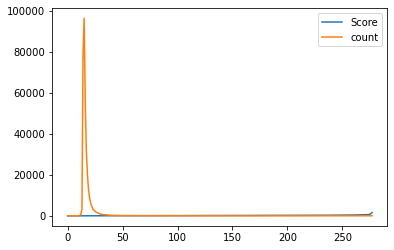

In [51]:
pandas_df.plot()

<AxesSubplot:>

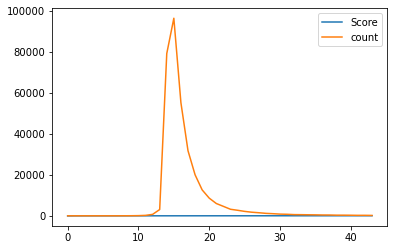

In [52]:
pandas_df[pandas_df['Score'] < 30].plot()

In [38]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

In [39]:
tokenizer = Tokenizer(inputCol="Body", outputCol="words")
words = tokenizer.transform(df)

In [40]:
words.select('Body', 'words').show()

+--------------------+--------------------+
|                Body|               words|
+--------------------+--------------------+
|<p>How should I e...|[<p>how, should, ...|
|<p>In many differ...|[<p>in, many, dif...|
|<p>What are some ...|[<p>what, are, so...|
|<p>I have two gro...|[<p>i, have, two,...|
|<p>The R-project<...|[<p>the, r-projec...|
|<p>Last year, I r...|[<p>last, year,, ...|
|<p>I've been work...|[<p>i've, been, w...|
|<p>Sorry, but the...|[<p>sorry,, but, ...|
|<p><a href="http:...|[<p><a, href="htt...|
|<p>Many studies i...|[<p>many, studies...|
|<p>Is there a goo...|[<p>is, there, a,...|
|<p>See my respons...|[<p>see, my, resp...|
|<p>Machine Learni...|[<p>machine, lear...|
|<p>I second that ...|[<p>i, second, th...|
|<p>John Cook give...|[<p>john, cook, g...|
|<p>Two projects s...|[<p>two, projects...|
|<p>I have four co...|[<p>i, have, four...|
|<p>Also see the U...|[<p>also, see, th...|
|<p><a href="http:...|[<p><a, href="htt...|
|<p>The assumption...|[<p>the, a

In [41]:
hashingTF = HashingTF(inputCol="words", outputCol="tf", numFeatures=20000)
featurized = hashingTF.transform(words)

In [42]:
featurized.select('words', 'tf').show()

+--------------------+--------------------+
|               words|                  tf|
+--------------------+--------------------+
|[<p>how, should, ...|(20000,[1547,1756...|
|[<p>in, many, dif...|(20000,[1756,2112...|
|[<p>what, are, so...|(20000,[157,763,1...|
|[<p>i, have, two,...|(20000,[592,763,1...|
|[<p>the, r-projec...|(20000,[763,876,1...|
|[<p>last, year,, ...|(20000,[9,576,739...|
|[<p>i've, been, w...|(20000,[585,592,6...|
|[<p>sorry,, but, ...|(20000,[1064,1989...|
|[<p><a, href="htt...|(20000,[2891,4845...|
|[<p>many, studies...|(20000,[823,1235,...|
|[<p>is, there, a,...|(20000,[468,763,8...|
|[<p>see, my, resp...|(20000,[1296,2269...|
|[<p>machine, lear...|(20000,[211,667,6...|
|[<p>i, second, th...|(20000,[1714,2029...|
|[<p>john, cook, g...|(20000,[2891,3509...|
|[<p>two, projects...|(20000,[146,157,3...|
|[<p>i, have, four...|(20000,[313,443,7...|
|[<p>also, see, th...|(20000,[1072,1695...|
|[<p><a, href="htt...|(20000,[804,4495,...|
|[<p>the, assumpti...|(20000,[57

In [43]:
idf = IDF(inputCol="tf", outputCol="features")
idf_model = idf.fit(featurized)
feature_matrix = idf_model.transform(featurized)

In [44]:
feature_matrix.select("Body", "features").show()

+--------------------+--------------------+
|                Body|            features|
+--------------------+--------------------+
|<p>How should I e...|(20000,[1547,1756...|
|<p>In many differ...|(20000,[1756,2112...|
|<p>What are some ...|(20000,[157,763,1...|
|<p>I have two gro...|(20000,[592,763,1...|
|<p>The R-project<...|(20000,[763,876,1...|
|<p>Last year, I r...|(20000,[9,576,739...|
|<p>I've been work...|(20000,[585,592,6...|
|<p>Sorry, but the...|(20000,[1064,1989...|
|<p><a href="http:...|(20000,[2891,4845...|
|<p>Many studies i...|(20000,[823,1235,...|
|<p>Is there a goo...|(20000,[468,763,8...|
|<p>See my respons...|(20000,[1296,2269...|
|<p>Machine Learni...|(20000,[211,667,6...|
|<p>I second that ...|(20000,[1714,2029...|
|<p>John Cook give...|(20000,[2891,3509...|
|<p>Two projects s...|(20000,[146,157,3...|
|<p>I have four co...|(20000,[313,443,7...|
|<p>Also see the U...|(20000,[1072,1695...|
|<p><a href="http:...|(20000,[804,4495,...|
|<p>The assumption...|(20000,[57

In [45]:
feature_matrix.count()

340838

In [46]:
# filter only question posts
questions = feature_matrix.dropna(subset=['Title', 'Body', 'features']).where(df.PostTypeId == 1)

In [47]:
questions.count()

171236

In [48]:
import numpy as np
from scipy.sparse import vstack, csr_matrix, save_npz

In [49]:
%%time
# WARNING: this takes ~5min to complete
matrices = questions.rdd.map(lambda e: e["features"]) \
                    .map(lambda v: csr_matrix((v.values, (np.zeros(len(v.indices), dtype='int32'), v.indices)), shape=(1, v.size))) \
                    .reduce(lambda x, y: vstack((x, y)))

CPU times: user 386 ms, sys: 5.82 s, total: 6.21 s
Wall time: 4min 40s


In [50]:
matrices

<171236x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 18138124 stored elements in Compressed Sparse Row format>

In [51]:
save_npz('data/features.npz', matrices)

In [52]:
np.save('data/labels.npy', questions.select("AcceptedAnswerId").toPandas().AcceptedAnswerId.notnull().values)

In [53]:
!ls -larth data

total 722M
-rw-r--r--  1 jovyan users 595M Feb 11 02:10 Posts.xml
drwxr-xr-x  2 jovyan users   64 Feb 20 18:18 .ipynb_checkpoints
drwxr-xr-x  6 jovyan users  192 Feb 21 16:08 .
drwxr-xr-x 12 jovyan users  384 Feb 21 16:15 ..
-rw-r--r--  1 jovyan users  99M Feb 21 16:19 features.npz
-rw-r--r--  1 jovyan users 168K Feb 21 16:20 labels.npy
